# Extreme Value Analysis Basic Tutorial
This tutorial covers a basic use case of the coastlib EVA toolkit. EVA is a class written in Python 3.6 to provide coastal and marine engineers with an accessible toolbox used to perform complex extreme value analysis. The EVA class features simple syntax which allows to access complex methods and concepts. The best way to learn a new tool is to use it in a real scenario - in this case we are going to analyze water levels at the NOAA Battery station in New York. Since we are interested in statistical properties of water levels, we need to remove trends from the data. In this case this was already done - sea level rise and tidal variation were removed from the data, leaving water level residuals, which are assumed to be stationary in time (not fully true, but a good enough assumption for this test). Lets dive into the analysis.

## Load data
First, we need to import requried modules and load data. Pre-processed data is available [here](https://www.dropbox.com/s/xgqp2v2f1foyrvb/battery_residuals.csv?dl=0). Let's load the data and plot Hurricane Sandy, which hit New York on October 29 2012, to get a feeling of what the data looks like.

**IMPORTANT NOTE :** input data for the EVA class must be a [pandas](https://pandas.pydata.org/) dataframe with index being date-time and column, in which the data to be analyzed is located, having data as real numbers (int of float).

In [1]:
import matplotlib.pyplot as plt
from coastlib.api import EVA
import pandas as pd

# Ignore warnings since this is a tutorial. Warnings are from scipy.stats.* trying to fit MLE using invalid parameters
# (e.g. scale < 0) and its internal optimizer throwing out warnings for receiving nan's
# (optimizer is general and is not related to MLE)
import warnings
warnings.filterwarnings('ignore')

# Don't forget to tell pandas that first column is index and to parse i as datetime
data = pd.read_csv(
    r'https://dl.dropboxusercontent.com/s/xgqp2v2f1foyrvb/battery_residuals.csv?dl=0',
    index_col=0, parse_dates=True
)

# Plot Hurricane Sandy data
mask = (data.index >= pd.Timestamp(year=2012, month=10, day=22)) & (data.index <= pd.Timestamp(year=2012, month=11, day=5))
sandy = data[mask]
fig = sandy.plot()

## Perform Extreme Value Analysis
### Initialize the EVA object
First we need to initialize the EVA object. During this step the EVA class loads data, pre-processes it, and determines parameters which are going to be further used in the analysis. First, we pass data to **dataframe** and tell which column to analyze by passing the column name to **column** (if not passed, assumes data is in the first column, which has index 0 in Python). **Block size** determines how we define return periods - it has units of days and by passing the value 365.2425 (1 Gregorian year) we say that return period of value=100 means 100-year return period (if we wanted monthly return periods, we would pass 365.2425/12). **Gap length** has units of hours and determines if data gaps are accounted for - e.g. if we have two chunks of data each being 3 months long, then, if they are separated by a gap of 5 months, they are treated as 6 months of data (if gap_length=None, then they would be treated as 11 months of data). Effectively, EVA finds gaps longer than gap_length and eliminates them by shifting all data "right" (future) from the gap to the "left" (past). This has a large effect on estimation of probabilities and return periods, especially for datasets with gaps (such as in this case, where we have several long gaps). Without gap_length return periods would be less conservative with a weak assumption of no extreme events occuring during periods with no data.

In [2]:
analysis = EVA(dataframe=data, column='Residuals (ft)', block_size=365.2425, gap_length=24)

### Extract extreme values
Now to the fun part - let's extract the extreme values. For this example we will use the Block Maxima (BM) method. Block maxima uses block sizes, which were defined during initialization of the EVA object - in our case, its 1 year. When extreme values are extracted, they are also assigned a return period (probability of exceedance). This is done using a user-specified plotting position (by default its Weibull, [read more here](https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_plot_pos.html)). In this example we pass it explicitly. See source code docstrings for available plotting positions. Plotting position has no effect on inference of the extreme return values. The only effects it has are visual representation of return values on plots and some goodness-of-fit statistics.

Let's extract and plot the extreme values. Extreme values plot shows extracted extreme values and boundaries of the blocks. The plot is interactive and displays information when hovering over points (interactive plots do not work well in Jupyter notebooks - run this code from Python directly for full functionality).

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22fa476a9b0>)

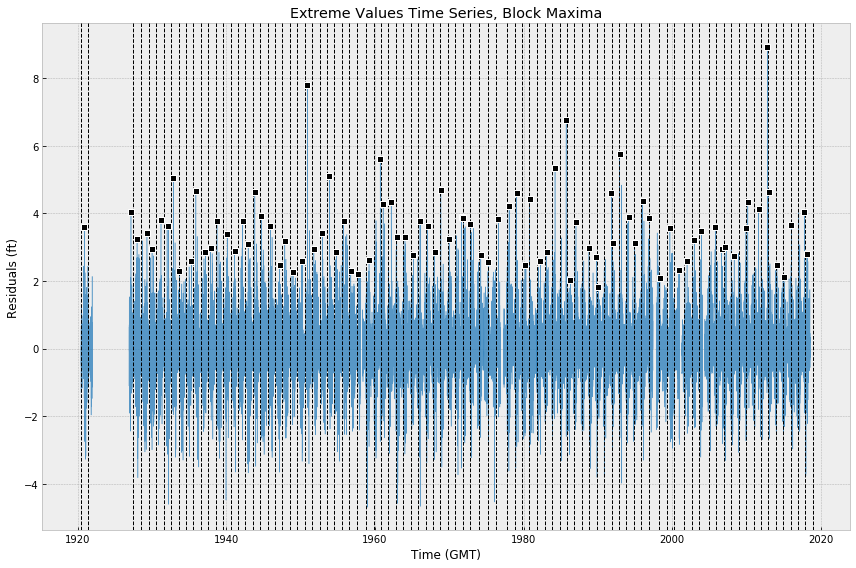

In [3]:
analysis.get_extremes(method='BM', plotting_position='Weibull')
analysis.plot_extremes()

### Fit the distribution
For the Block Maxima extreme value extraction method the common practice is to use the Generalied Extreme Value distribution ([read more here](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution)). The GEV distribution encapsulates three classic types of extreme value distributions, which, as was theoretically proven, cover all possible distributions of block maxima extremes. These three types are: Gumbel (Type I), Fréchet (Type II), and Weibull (Type III). The initial guess for the distribution type will be very general and light on assumptions - it will be the 3-parameter GEV distribution. Let's fit it using the Maximum Likelihood Estimate (MLE) method, estimate confidence intervals using the Delta method, and plot results to see how well the selected model fits the data.

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22faa1ddfd0>)

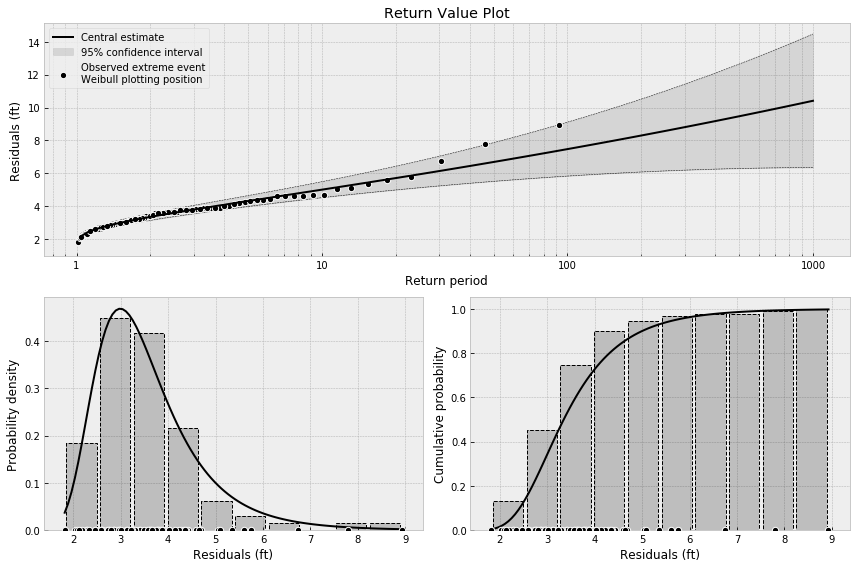

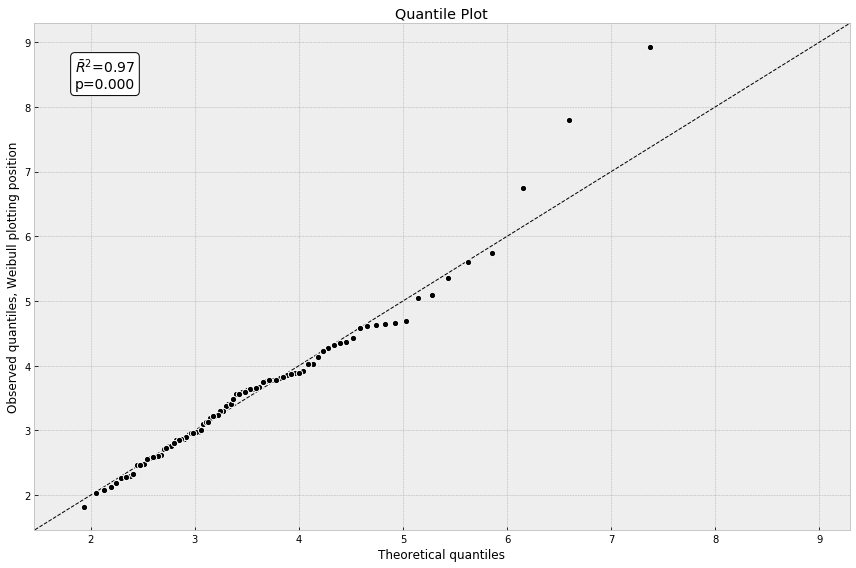

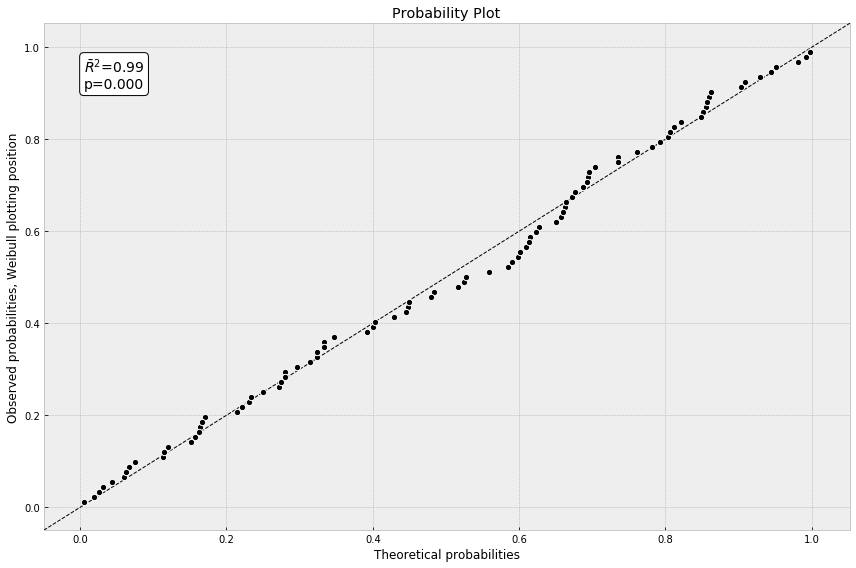

In [4]:
# Dsitribution names come form scipy.stats, see https://docs.scipy.org/doc/scipy/reference/stats.html
analysis.fit(distribution_name='genextreme', fit_method='MLE')

# Return value (summary) plot
# See available confidence interval estimation methods in EVA docstrings (Delta is fast, but not accurate)
analysis.generate_results(alpha=.95, ci_kwargs=dict(method='Delta'))

# See available plotting positions in EVA docstrings
analysis.plot_summary(bins=10, plotting_position='Weibull')

# QQ plot
analysis.plot_qq(quantiles=True, plotting_position='Weibull', k=3)

# PP plot
analysis.plot_qq(quantiles=False, plotting_position='Weibull', k=3)

Let's print out the Akaike Information Criteria (AIC, [see more here](https://en.wikipedia.org/wiki/Akaike_information_criterion)) and analysis summary to get an overview of the model.

In [5]:
# k stands for number of parameters, order=2 for small samples
print(f'AIC = {analysis.goodness_of_fit(method="AIC", order=2, k=3):.2f}')
# Print the EVA object instance at any time to see its summary
print(analysis)

AIC = 258.38
                                   Extreme Value Analysis Summary
Analyzed parameter               Residuals (ft)      Series length                     35854.75 days
Gap length                          24.00 hours      Adjusted series length            33237.07 days
Block size                          365.24 days      Number of blocks                          91.00
Number of extreme events                     91      Extraction method                  Block Maxima
Extreme event rate            1.00 events/block      Plotting position                       Weibull
Threshold                                  0.00      Extreme values type                        high
Distribution                         genextreme      Fit method          Maximum Likelihood Estimate
MLE fit parameters       [-0.083  3.053  0.788]


### Test for degeneracy
Now lets see if the model can be simplified by using one of the 3 types of distributions discussed before. Since the shape parameter is close to 0, it would be reasonable to try to approximate the model as a 2-parameter Gumbel distribution. This is equivalent to a GEV model degenerate in its shape parameter (i.e. shape parameter is fixed to the value of 0). Let's apply the same procedures to the Gumbel model as for the GEV before.

**IMPORTANT NOTE :** EVA remembers the choice of fixed parameters and carries it over to subsequent calculation steps. Read [scipy.stats documentation](https://docs.scipy.org/doc/scipy/reference/stats.html) to understand how fixed parameters should be specified.

AIC = 257.71
                                   Extreme Value Analysis Summary
Analyzed parameter               Residuals (ft)      Series length                     35854.75 days
Gap length                          24.00 hours      Adjusted series length            33237.07 days
Block size                          365.24 days      Number of blocks                          91.00
Number of extreme events                     91      Extraction method                  Block Maxima
Extreme event rate            1.00 events/block      Plotting position                       Weibull
Threshold                                  0.00      Extreme values type                        high
Distribution                         genextreme      Fit method          Maximum Likelihood Estimate
MLE fit parameters          [0.    3.09  0.814]


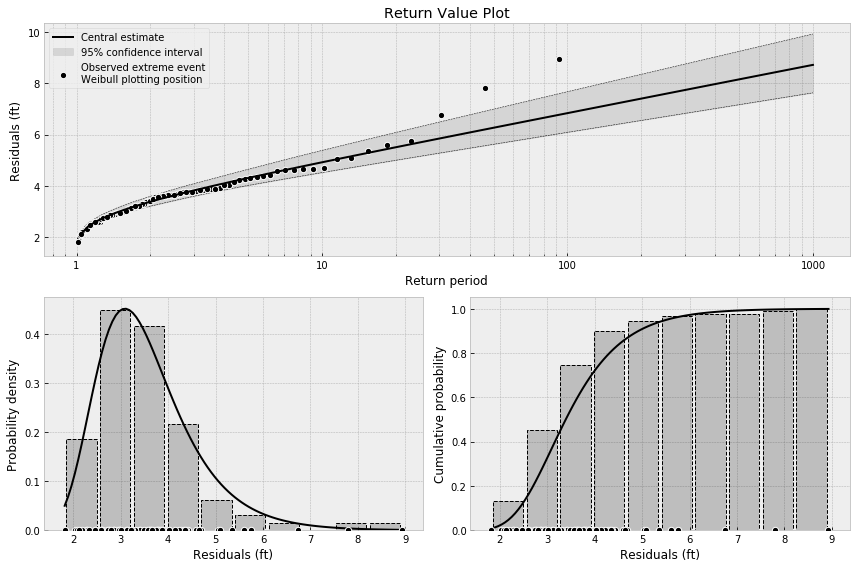

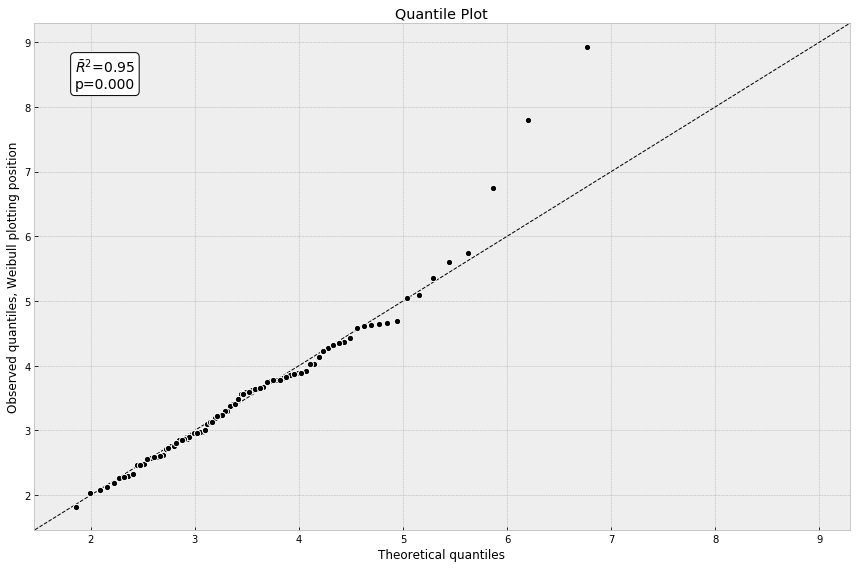

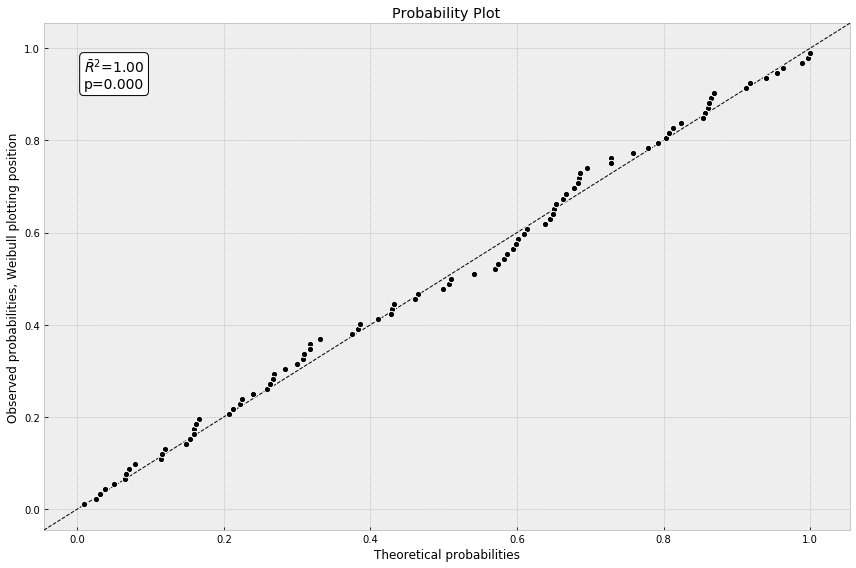

In [6]:
# Dsitribution names come form scipy.stats, see https://docs.scipy.org/doc/scipy/reference/stats.html
# f0 stands for fixed shape parameter
analysis.fit(distribution_name='genextreme', fit_method='MLE', scipy_fit_options=dict(f0=0))

# Return value (summary) plot
# Delta method is currently not implemented for fixed-parameter GEV distributions
analysis.generate_results(alpha=.95, ci_kwargs=dict(method='Monte Carlo', k=100))

# See available plotting positions in EVA docstrings
analysis.plot_summary(bins=10, plotting_position='Weibull')

# QQ plot
analysis.plot_qq(quantiles=True, plotting_position='Weibull', k=2)

# PP plot
analysis.plot_qq(quantiles=False, plotting_position='Weibull', k=2)

# k stands for number of parameters (we have fixed shape, so now its 2), order=2 for small samples
print(f'AIC = {analysis.goodness_of_fit(method="AIC", order=2, k=2):.2f}')
print(analysis)

AIC suggests that the Gumbel and GEV models are equivalent based on values of penalized likelihood. The Gumbel model is chosen as a simpler model - it can explain the same amount of variance (information) as the GEV, while making less assumptions about the data and, by the virtue of having less parameters, providing much narrower confidence intervals.
### Perform a production run of the model
Now, after we have made an informed choice of model, it is time to perform a production run of the model. The only difference from previous steps is that now we perform a proper Monte Carlo simulation with a large number of samples to get accurate estimates of confidence bounds. This is much more accurate than the Delta method shown earlier, since MC doesn't make any assumptions about the return value distribution (Delta assumes asymptotic normality, which is clearly violated as shown below).

(<Figure size 864x576 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22fad082b38>)

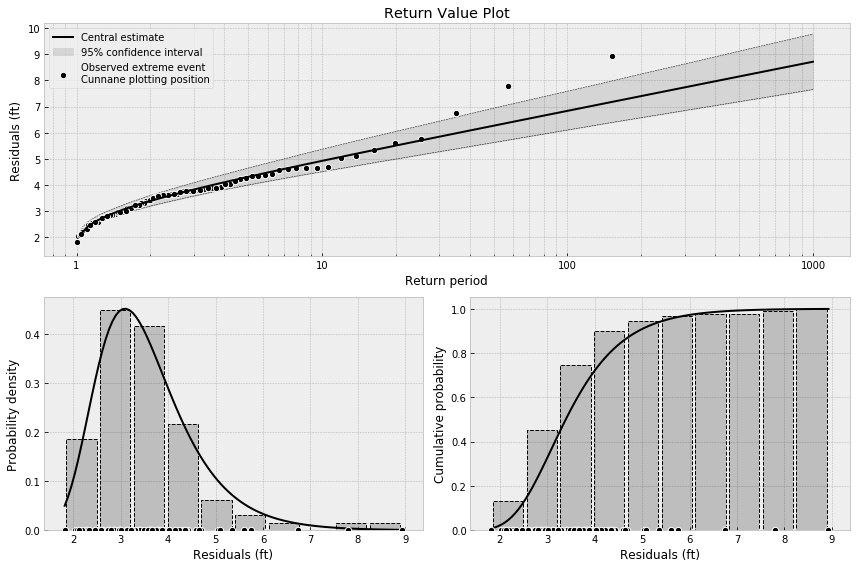

In [7]:
analysis.fit(distribution_name='genextreme', fit_method='MLE', scipy_fit_options=dict(f0=0))
analysis.generate_results(
    alpha=.95,
    ci_kwargs=dict(method='Monte Carlo', k=1e3, source='data', sampling_method='constant', assume_normality=False)
)
analysis.plot_summary(bins=10, plotting_position='Cunnane')

Analysis results can be exported to a csv file by calling `analysis.results.to_csv(path/to/excel.csv)`. For more export options see [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/api.html#id12). If results for additional return periods are needed, the `rp` argument with an array of return periods can be passed to `analysis.generate_results(rp=array)`.
#### Remarks
Additional methods, such as `to_pickle`, `read_pickle`, `return_value`, `confidence_interval`, and many others, are available for the Block Maxima method. Information on how to use these methods can be found in the EVA source dosctrings. 